In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output

In [51]:
class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(noise_size, 512, 4, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 2, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 1, 1, 1, 1, bias=False),
            nn.Tanh()
            
        )
        self.noise_size = noise_size
        
    def forward(self, x):
        return self.main(x)
    
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Conv2d(1, 64, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 2, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        #return self.main(x).view(-1, 1)
        return x.view(-1,1)
    
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(8192, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 10, bias=True)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.main(x).squeeze()

In [56]:
class Trainer:
    def __init__(self, generator, front_end, discriminator, Q, metrics=[]):
        self.generator = generator.cuda()
        self.front_end = front_end.cuda()
        self.discriminator = discriminator.cuda()
        self.Q = Q.cuda()
        
        self.noise_size = generator.noise_size
        self.batch_size = 100
    
        self.metrics = metrics
        self.seed = 6999
    
    def refresh_metrics(self):
        tmp = self.metrics
        self.metrics = []
        return tmp
    
    def _noise_eval(self):
        cluster_num = 10
        
        idx = np.arange(cluster_num)
        c = np.zeros((cluster_num, cluster_num))
        c[range(cluster_num), idx] = 1.0
        z = torch.cat([torch.FloatTensor(1, self.noise_size - cluster_num).uniform_(-1.0, 1.0).expand(cluster_num, self.noise_size - cluster_num), 
            torch.Tensor(c)] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
    
    def _noise_idx(self, idx):
        cluster_num = 10
        
        c = np.zeros((len(idx), cluster_num))
        c[range(len(idx)), idx] = 1.0
        
        z = torch.cat([
            torch.FloatTensor(len(idx), self.noise_size - cluster_num).uniform_(-1.0, 1.0),
            torch.Tensor(c)], 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
        
    def _noise_sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        # gen condition c
        cluster_num = 10
        idx = np.random.randint(cluster_num, size=batch_size)
        c = np.zeros((batch_size, cluster_num))
        c[range(batch_size), idx] = 1.0
        
        # gen torch (batch, #noise, 1, 1)
        z = torch.cat([
            torch.FloatTensor(batch_size, self.noise_size - cluster_num).uniform_(-1.0, 1.0), 
            torch.Tensor(c)] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
    
    def train(self, dataset, batch_size, epoch_size, show=False):
        self.batch_size = batch_size
        
        criterion_D = nn.BCELoss().cuda()
        criterion_Q = nn.CrossEntropyLoss().cuda()
        
        optimize_Disc = optim.Adam(
            [{'params':self.front_end.parameters()}, {'params':self.discriminator.parameters()}],
            lr = 0.0002, betas=(0.5, 0.99)
        )
        optimize_Gen = optim.Adam(
            [{'params':self.generator.parameters()}, {'params':self.Q.parameters()}],
            lr = 0.001, betas=(0.5, 0.99)
        )
        
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)
        
        # check train mode
        self.generator.train()
        self.front_end.train()
        self.discriminator.train()
        self.Q.train()
        
        # prepare some tensor for training
        label = torch.FloatTensor(self.batch_size, 1).cuda()
        
        for epoch in range(len(self.metrics), epoch_size):
            batch_metrics = []
            for batch, batch_data in enumerate(dataloader, 0):
                
                # Discriminator part
                optimize_Disc.zero_grad()
                
                # Feed real image
                x, _ = batch_data
                
                bs = x.size(0)
                label.data.resize_(bs, 1)
                
                real_x = x.cuda()
                
                real_out = self.discriminator(self.front_end(real_x))
                
                label.data.fill_(1.0)
                loss_Disc_real = criterion_D(real_out, label)
                
                loss_Disc_real.backward()
                
                # Feed fake image from generator
                z, idx = self._noise_sample(bs)
                
                fake_x = self.generator(z)
                fake_out = self.discriminator(self.front_end(fake_x.detach()))
                
                label.data.fill_(0.0)
                loss_Disc_fake = criterion_D(fake_out, label)
                
                loss_Disc_fake.backward()
                
                optimize_Disc.step()
                
                loss_Disc = loss_Disc_real + loss_Disc_fake
                
                #implement Generate Loss
                optimize_Gen.zero_grad()
                
                f_e_out = self.front_end(fake_x)
                ad_out = self.discriminator(f_e_out)
                
                label.data.fill_(1.0)
                
                loss_Gen_reconstruct = criterion_D(ad_out, label)
                
                c = self.Q(f_e_out)

                loss_Q = criterion_Q(c, idx)
                
                loss_Gen = loss_Gen_reconstruct + loss_Q
                loss_Gen.backward()
                
                optimize_Gen.step()
                
                fake_x = self.generator(z)
                fake_out_after = self.discriminator(self.front_end(fake_x.detach()))
                
                if batch % 100 == 0:

                    if show:
                        showImage(self.evaluation(seed=self.seed))
                    clear_output(wait=True)
                
                # calculate probability
                # real
                r = torch.mean(real_out).item()
                # fake before
                f_b = torch.mean(fake_out).item()
                # fake after
                f_a = torch.mean(fake_out_after).item()
                
                batch_metrics.append( (loss_Gen.item(), loss_Disc.item(), loss_Q.item(), r, f_b, f_a) )
                    
            # store metrics
            self.metrics.append( batch_metrics )
    
    def evaluation(self, noise_num=10, seed=None):
        
        if seed is None:
            import time
            seed = time.time()
        
        self.generator.eval()
        
        x = []
        torch.manual_seed(seed)
        for i in range(noise_num):
            z, _ = self._noise_eval()
            x.append( self.generator(z) )
        
        x = torch.cat(x, dim=0)
        
        self.generator.train()
        
        return x.detach().cpu()
    
    def evaluation_with_idx(self, idxs, seed=None):
        
        if seed is None:
            import time
            seed = time.time()
        
        self.generator.eval()
        
        x = []
        torch.manual_seed(seed)
        
        z, _ = self._noise_idx(idxs)
        
        x = self.generator(z)
        
        self.generator.train()
        
        return x.detach().cpu()

In [40]:
def convertDataToImage(data, row, col):
    return MNIST_inverse_transform(
        torch.cat([
            torch.cat([
                data[i*col + j] 
                for j in range(col)
            ] , dim=2)
            for i in range(row)
        ], dim=1)
    )

def showImage(data):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(convertDataToImage(data, 10, 10), cmap='gray')
    plt.show()
    return fig

def demo(trainer, idxs):
    plt.figure(figsize=(3, 3*len(idxs)))
    plt.imshow(convertDataToImage(trainer.evaluation_with_idx(idxs), len(idxs), 1), cmap='gray')

In [47]:
def showCurve(metrics, window_size=100):
    from functools import reduce
    a = np.array(reduce(lambda x,y : x+y, metrics))
    a = np.concatenate(

    [
        np.average(a[i*window_size:(i+1)*window_size, :], axis=0).reshape(1, -1) 
        for i in range(a.shape[0] // window_size)
    ] , axis=0)
    
    s = (12,3)
    
    x = range(1, a.shape[0]+1)
    
    # show loss curve
    plt.figure(figsize=s)
    plt.title('Training loss curves')
    plt.plot(x,a[:,0], label='Generator Loss',color='green')
    plt.plot(x,a[:,1], label='Discriminator Loss', color='pink')
    plt.plot(x,a[:,2], label='Q Loss',color='brown')
    plt.xlabel('each {} batch'.format(window_size))
    plt.ylabel('Loss')
    plt.legend()

    
def save_trainer(trainer, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, 'trainer.pkl')
    torch.save(trainer, p)
    return p
    
def load_trainer(root):
    p = os.path.join(root, 'trainer.pkl')
    return torch.load(p)

In [42]:
MNIST_mean = 0.1307
MNIST_std = 0.3081

MNIST_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (MNIST_mean,), (MNIST_std,)
    )
])

MNIST_inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x*MNIST_std + MNIST_mean),
    torchvision.transforms.ToPILImage()
])

mnist_dataset = torchvision.datasets.MNIST(
    './mnist_datset', train=True, download=True, 
    transform=MNIST_transform
)

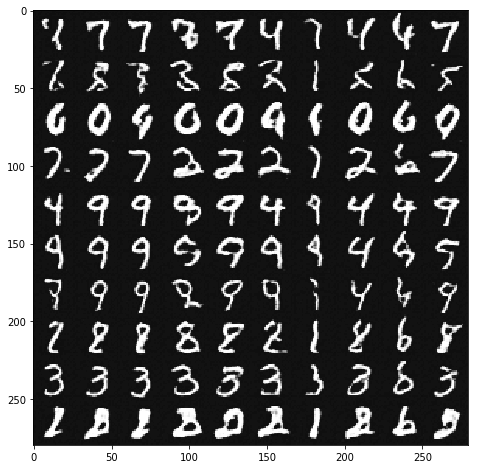

In [61]:
torch.manual_seed(201905)
t = Trainer(Generator(64), FrontEnd(), Discriminator(), Q(), [])


t.train(mnist_dataset, 64, 2, show=True)

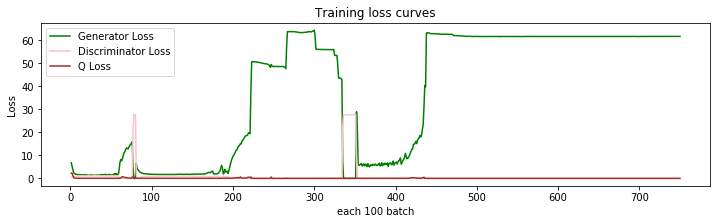

In [53]:
showCurve(t.metrics)